In [0]:
from pyspark.sql.functions import udf, col
from pyspark.sql import functions as sf
from pyspark.sql.types import BooleanType

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import detrend, find_peaks_cwt

import random

In [0]:
#######################################
# Set RNG seed for reproducible results
#######################################
np.random.seed(42)
random.seed(42)

In [0]:
############################
# MDR dataset pre-processing
############################

input_data_source = "/FileStore/tables/apac_MDR4_PNC925060333_SN82971631_0419.csv"
appliance_id = "925060333_00:82971631-C83DD42B5CFF"

# Constants
ACCEPTABLE_RANGES = {
    "DefrostTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "SensorTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "AmbientTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "TargetTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "CompressorSpeed": {
        "CR1": [0, 4500],
        "CR1/RC1": [0, 4500],
        "CR1/IC1": [0, 4500],
        "CR1/FC1": [0, 4500],
        "CR1/XC1": [0, 4500]
    },
    "WaterFilterFlow": {
        "CR1": [100, 250],
        "CR1/RC1": [100, 250],
        "CR1/IC1": [100, 250],
        "CR1/FC1": [100, 250],
        "CR1/XC1": [100, 250]
    }
}

USEFUL_COLUMNS = ["id", "source_ts", "gateway_ts", "appliance_id", "pnc", "sn", "module_path", "property_name", "value",
                  "value_code", "is_parent", "parent_id", "prev_value", "value_type"]

COEFFICIENT_BASED_COMPOSED_SIGNALS = ['SensorTemperature', 'AmbientTemperature', 'DefrostTemperature',
                                      'TargetTemperature', 'CompressorSpeed', 'WaterFilterFlow']

NUMBER_OF_DECIMALS = 5

def get_containers(df_to_process):
    return df_to_process.filter(df_to_process.value_code == "Container")


def get_null_for_column(df_to_process, column):
    return df_to_process.filter("{} is null".format(column))


def resolution_temperature_speed(props, vals):
    try:
        coef_index = props.index('Coefficient')
        coef_val = vals[coef_index]
    except ValueError:
        return None

    try:
        expo_index = props.index('Exponent')
        expo_val = vals[expo_index]
    except ValueError:
        return None

    return int(coef_val) * (10 ** int(expo_val))


def resolution_default(props, vals):
    props = ';'.join(str(e) for e in props)
    values = ';'.join(str(e) for e in vals)
    return 'defaultComputation: ' + props + '=' + values


def compose_value_udf(property_name, props, vals):
    if property_name in COEFFICIENT_BASED_COMPOSED_SIGNALS:
        value = resolution_temperature_speed(props, vals)
    else:
        value = resolution_default(props, vals)

    return value


compose_value = spark.udf.register("compose_value", compose_value_udf)


def list_to_string_udf(list):
    return ';'.join(list)


list_to_string = spark.udf.register("list_to_string", list_to_string_udf)


def compose_containers(df_to_process):
    df1 = df_to_process
    df2 = df1.select(*(col(x).alias('p_' + x) for x in df1.columns))
    left_join = df1.join(df2, df1.parent_id == df2.p_id, how='left')
    only_base_from_left_join = left_join.where('parent_id is not null').groupBy("parent_id").agg(
        sf.first("p_source_ts").alias("source_ts"),
        sf.first("p_gateway_ts").alias("gateway_ts"),
        sf.first("p_appliance_id").alias("appliance_id"),
        sf.first("p_pnc").alias("pnc"),
        sf.first("p_sn").alias("sn"),
        sf.first("p_module_path").alias("module_path"),
        sf.first("p_property_name").alias("property_name"),
        sf.collect_list("property_name").alias('properties'),
        sf.collect_list("value").alias('value'),
        sf.collect_list("value_code").alias('value_code'),
        sf.first("p_is_parent").alias("is_parent"),
        sf.first("parent_id").alias("parent_id_of_base"),
        sf.collect_list("prev_value").alias('prev_value'),
        sf.collect_list("value_type").alias('value_type')
    )

    composed_containers_as_list = only_base_from_left_join.selectExpr("parent_id as id", "source_ts", "gateway_ts",
                                                                      "appliance_id", "pnc", "sn", "module_path",
                                                                      "property_name", "properties", "value",
                                                                      "value_code", "is_parent",
                                                                      "parent_id_of_base as parent_id", "prev_value",
                                                                      "value_type")

    composed_containers = composed_containers_as_list.select("id", "source_ts", "gateway_ts", "appliance_id", "pnc",
                                                             "sn", "module_path", "property_name",
                                                             compose_value(col("property_name"), col("properties"),
                                                                           col("value")).alias('value'),
                                                             list_to_string(col('value_code')).alias('value_code'),
                                                             "is_parent", "parent_id",
                                                             list_to_string(col("prev_value")).alias('prev_value'),
                                                             list_to_string(col("value_type")).alias('value_type'))

    return composed_containers


def get_simple_properties(df_to_process):
    return df_to_process.filter(
        "{} is null and ({} <> 'Container'  or {} is null)".format("parent_id", "value_code", "value_code"))


def composition(df_to_process):
    composed_containers = compose_containers(df_to_process)
    simple_properties_df = get_simple_properties(df_to_process)
    composed_data_frame = composed_containers.union(simple_properties_df)
    return composed_data_frame.sort('source_ts')


def is_value_valid(property_name, module_path, value):
    try:
        if ACCEPTABLE_RANGES.get(property_name).get(module_path)[0] <= float(value) <= \
                ACCEPTABLE_RANGES.get(property_name).get(module_path)[1]:
            return True
        return False
    except ValueError:
        return True
    except AttributeError:
        return True


filter_outliers_udf = udf(is_value_valid, BooleanType())


def remove_outliers(composed_data_frame_to_process):
    df_with_outliers_removed = composed_data_frame_to_process.filter(
        filter_outliers_udf(composed_data_frame_to_process.property_name, composed_data_frame_to_process.module_path,
                            composed_data_frame_to_process.value))

    return df_with_outliers_removed


def get_difference(initial_df, cleaned_df):
    return initial_df.count() - cleaned_df.count()


def remove_duplicates(df_to_process):
    df_without_duplicates = df_to_process.select("*")
    return df_without_duplicates.dropDuplicates(
        ["source_ts", "gateway_ts", "appliance_id", "pnc", "sn", "module_path", "property_name", "value", "value_code",
         "is_parent", "parent_id", "prev_value", "value_type"])

In [0]:
#########################
# Periodicity algorithm 1
#########################

def detect_transmission_periodicity_A1(df, start_ts, end_ts, TH=10, hist_bins=100, rm_duplicates=False, debug=False):
  """ Detect periodicity in extracted signal.
  Args:
    df(pd.DataFrame): input signal, with timestamp column named 'source_ts'
    start_ts, end_ts: time interval considered
    TH(int): periodicity threshold
    hist_bins(int): number of bins for the histogram
    rm_duplicates(bool): remove duplicate timestamps (period(t) == 0)
    
  Returns:
    transmission periodicity of signal
  """
  df = df[(df.source_ts >= start_ts) & (df.source_ts <= end_ts)]
  df = df.reset_index(drop=True)
  
  df['next'] = df.shift(-1)
  df.dropna(inplace=True)
  df['period'] = (df['next'] - df['source_ts']).dt.total_seconds()
  
  if rm_duplicates:
    df = remove_duplicate_timestamps(df)
  
  if debug:
    ax = df.plot.line(x='source_ts', y='period', title="period(t) function")
    ax.set_xlabel("source_ts")
    ax.set_ylabel("period")
    plt.show()
  
  return get_signal_period(df, hist_bins, TH)
  
def get_period_histogram(df, num_bins, TH, remove_outliers=False):
  """ Compute histogram of period(t) function and decide whether the signal is periodic.
  Args:
    df(pd.DataFrame): input signal, with precomputed values for column named 'period'
    num_bins(int): number of bins for the histogram
    TH(int): periodicity threshold
    remove_outliers(bool): remove outlier values from period(t) prior to building the histogram
  
  Returns:
    transmission periodicity identified, -1 otherwise
    values of histogram bins
  """
  if remove_outliers:
    period_mean = df.period.mean()
    period_std = df.period.std()
    print(f"Period(t): mean={period_mean}, stddev={period_std}")
    df = df[np.abs(df.period - period_mean) < 3 * period_std]
  
  hist_counts, hist_bins, _ = plt.hist(df.period, bins=num_bins)
  plt.xlabel("period(t) value")
  plt.ylabel("counts")
  std_dev = np.std(hist_counts)
  print("Histogram stddev: {:.2f}".format(std_dev))
  
  if std_dev > TH:
    return -1, hist_counts
  else:
    max_value_idx = np.argmax(hist_counts)
    return hist_bins[max_value_idx], hist_counts
  
def remove_duplicate_timestamps(df):
  """ Remove duplicate timestamps (for which period(t) == 0)
  Args:
    df(pd.DataFrame): input signal, with precomputed values for column named 'period'
  
  Returns:
    the modified DataFrame
  """
  df = df[df.period != 0]
  df = df.reset_index(drop=True)
  return df

def compute_period_function(df):
  df['next'] = df.shift(-1)
  df.dropna(inplace=True)
  df['period'] = (df['next'] - df['source_ts']).dt.total_seconds()
  return df

def extract_timestamps(df, signal_name, module_path):
  """ Extract the timestamp values for a given property and module.
  Args:
    df(pyspark.DataFrame): input dataset
    signal_name: name of property
    module_path: name of module
  Returns:
    a pd.DataFrame with timestamp values
  """
  df = df.filter(df.property_name == signal_name).filter(df.module_path == module_path)
  signal = df.select("source_ts").orderBy("source_ts")
  return signal.toPandas()

In [0]:
####################
# Plotting functions
####################

def plot_peak_detection(signal, peaks, title=''):
  ax = signal.plot.line(x='source_ts', y='period', title=title)
  ax.set_xlabel("source_ts")
  ax.set_ylabel("period")
  ax.scatter(peaks.source_ts, peaks.period, marker='o', color='red')
  
def plot_period_function(signal, title=''):
  ax = signal.plot.line(x='source_ts', y='period', title=title)
  ax.set_xlabel("source_ts")
  ax.set_ylabel("period")

In [0]:
############################
# Peak detection algorithm 1
############################

k = 4
h = 1
WINDOW_SIZE = 2 * k + 1

def peak_function_1(x):
  """ Computes the average of:
  1) the maximum signed distance between the center of the window and the left neighbors and
  2) the maximum signed distance between the center of the window and the right neighbors
  """
  x = np.array(x)
  M = len(x) // 2
  max_1 = np.max([x[M] - x[i] for i in range(0, M)])
  max_2 = np.max([x[M] - x[i] for i in range(M + 1, len(x))])
  return (max_1 + max_2) / 2


def peak_function_2(x):
  """ Computes the average of:
  1) the average of the signed distances between the center of the window and the left neighbors and
  2) the average of the signed distances between the center of the window and the right neighbors
  """
  x = np.array(x)
  M = len(x) // 2
  mean_1 = np.mean([x[M] - x[i] for i in range(0, M)])
  mean_2 = np.mean([x[M] - x[i] for i in range(M + 1, len(x))])
  return (mean_1 + mean_2) / 2


def peak_function_3(x):
  """ Computes the average of the signed distance between the center of the window and 
  the average values of the left and right neighbors.
  """
  x = np.array(x)
  M = len(x) // 2
  mean_1 = np.mean(x[0:M])
  mean_2 = np.mean(x[M+1:len(x)])
  return ((x[M] - mean_1) + (x[M] - mean_2)) / 2


def peak_function_5(x):
  """ Considers a point as a peak if it is an outlier in the window centered in it.
  A point is an outlier if it is larger than the mean of the points in the window and it is at a distance more than h standard deviations from the mean.
  """
  x = np.array(x)
  M = len(x) // 2
  mean = np.mean(x)
  std_dev = np.std(x)
  if x[M] >= mean and np.abs(x[M] - mean) >= h * std_dev:
    return x[M]
  else:
    return 0
  
  
def peak_detection_algo_1(df, peak_function, window_size=WINDOW_SIZE, debug=False):
  """ Detect peaks in the given time series.
  Args:
    df(pd.DataFrame): input time series
    peak_function: the function used for scoring peaks
    window_size(int): width of window used by peak function
    h(float): parameter expressing the importance of a local peak to the global context
  Returns:
    the identified peaks
  """
  
  peak_function_values = df['period'].rolling(window_size, center=True).apply(peak_function)
  if debug:
    print("Number of initial points: {:.2f}".format(len(peak_function_values)))
  
  peak_function_values = peak_function_values[peak_function_values > 0]
  if debug:
    print("Number of candidate peaks: {:.2f}".format(len(peak_function_values)))
  
  mean = peak_function_values.mean()
  std_dev = peak_function_values.std()
  if debug:
    print(f"Mean: {mean}")
    print(f"Standard deviation: {std_dev}")
  
  peak_function_values = peak_function_values[(peak_function_values - mean) > h * std_dev]
  peaks = df[df.index.isin(peak_function_values.index.values)]
  
  # Postprocessing step
  if len(peaks) >= 2:
    indexes = np.array(peaks.index)
    shifted_indexes = np.array(pd.Series(indexes).shift(-1, fill_value=0))
    mask = np.abs(shifted_indexes - indexes) > k
    mask[-1] = True
    peaks.drop(indexes[~mask], axis='index')
  
  print("Found {} peaks".format(len(peaks)))
  return peaks


def compare_peak_functions_algo_1(signal):
  peaks_1 = peak_detection_algo_1(signal, peak_function_1)
  peaks_2 = peak_detection_algo_1(signal, peak_function_2)
  peaks_3 = peak_detection_algo_1(signal, peak_function_3)
  peaks_5 = peak_detection_algo_1(signal, peak_function_5)


  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
  # fig.set_title("Period function for {}, module {}".format(signal_name, module_path))

  signal.plot.line(x='source_ts', y='period', ax=axes[0, 0])
  axes[0, 0].scatter(peaks_1.source_ts, peaks_1.period, marker='o', color='red')
  axes[0, 0].set_title('Peak function 1')

  signal.plot.line(x='source_ts', y='period', ax=axes[0, 1])
  axes[0, 1].scatter(peaks_2.source_ts, peaks_2.period, marker='o', color='red')
  axes[0, 1].set_title('Peak function 2')

  signal.plot.line(x='source_ts', y='period', ax=axes[1, 0])
  axes[1, 0].scatter(peaks_3.source_ts, peaks_3.period, marker='o', color='red')
  axes[1, 0].set_title('Peak function 3')

  signal.plot.line(x='source_ts', y='period', ax=axes[1, 1])
  axes[1, 1].scatter(peaks_5.source_ts, peaks_5.period, marker='o', color='red')
  axes[1, 1].set_title('Peak function 5')

  for ax in axes.flat:
    ax.set(xlabel='source_ts', ylabel='period')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axes.flat:
    ax.label_outer()

In [0]:
############################
# Peak detection algorithm 2
############################

def multiscale_peak_detection(x, max_scale=None, debug=False):
    # x = detrend(x)
    N = len(x)
    L = N // 2
    if max_scale:
      L = min(L, max_scale)

    # LMS[i, j] is True if j is a peak at scale i
    LMS = np.zeros((L, N), dtype=bool)
    
    for k in np.arange(1, L):
      # x(i) is a local maxima at scale k if x(i) > x(i - k) and x(i) > x(i + k) 
      LMS[k - 1, k:N - k] = (
        (x[0:N - 2 * k] < x[k:N - k]) & (x[k:N - k] > x[2 * k:N])
      )

    gamma = LMS.sum(axis=1)
    
    # Find scale with most local maxima
    l = np.argmax(gamma)
    if debug:
      print("Row-wise sums: {}".format(gamma))
      print("Scale with most local maxima: {}".format(l))
      
    if 0 <= l <= 1:
      return np.flatnonzero(LMS[0, :])

    # Find peaks that are present on all scales up to l
    peaks = np.min(LMS[0:l, :], axis=0)
    if debug:
      print("Min: ", peaks)
    peaks = np.flatnonzero(peaks)
    return peaks
  
def peak_detection_algo_2(signal, max_scale=None, debug=False):
  peak_idx = multiscale_peak_detection(np.array(signal.period), max_scale=max_scale, debug=debug)
  peaks = signal[signal.index.isin(peak_idx)]
  print("Found {} peaks".format(len(peaks)))
  plot_peak_detection(signal, peaks)
  return peaks

In [0]:
############################
# Peak detection algorithm 3
############################

def peak_detection_algo_3(signal):
  peak_idx = find_peaks_cwt(signal.period, [0.1])
  print("Found {} peaks".format(len(peak_idx)))
  
  peak_idx += signal.index[0]
  peaks = signal[signal.index.isin(peak_idx)]
  plot_peak_detection(signal, peaks)
  return peaks

def generate_syntetic_period_signal(N=1000, num_transmission_gaps=10):
  signal = np.ones(N) * 300
  
  np.random.seed(42)
  transmission_gaps = []
  indexes = np.random.randint(1, N, num_transmission_gaps)
  
  # Add transmission gaps
  for i in range(num_transmission_gaps):
    val = np.random.randint(10, 2000)
    signal[indexes[i]] += val
    transmission_gaps.append((indexes[i], signal[indexes[i]]))
    
  # Add duplicate transmissions
  for i in range(100):
    idx = np.random.randint(1, N)
    signal[idx] = 0
    
  return signal, transmission_gaps

In [0]:
#################################
# Data reading and pre-processing
#################################
df = spark.read.csv(input_data_source, inferSchema=True, header=True)
df = df.filter(df.appliance_id == appliance_id)
df = df.select(USEFUL_COLUMNS)
df.printSchema()

root
-- id: integer (nullable = true)
-- source_ts: timestamp (nullable = true)
-- gateway_ts: timestamp (nullable = true)
-- appliance_id: string (nullable = true)
-- pnc: integer (nullable = true)
-- sn: integer (nullable = true)
-- module_path: string (nullable = true)
-- property_name: string (nullable = true)
-- value: string (nullable = true)
-- value_code: string (nullable = true)
-- is_parent: string (nullable = true)
-- parent_id: integer (nullable = true)
-- prev_value: string (nullable = true)
-- value_type: string (nullable = true)

In [0]:
composed_df = composition(df)
filtered_composed_df = composed_df.filter(composed_df.value.isNotNull())
preprocessed_df = remove_duplicates(filtered_composed_df)
preprocessed_df = remove_outliers(preprocessed_df)

In [0]:
preprocessed_df.select('property_name').distinct().collect()

Out[6]: [Row(property_name='DefrostTemperature'),
 Row(property_name='CompressorState'),
 Row(property_name='EvaporatorFanState'),
 Row(property_name='LinkQualityIndicator'),
 Row(property_name='TemperatureRepresentation'),
 Row(property_name='WaterFilterState'),
 Row(property_name='FastModeTimeToEnd'),
 Row(property_name='DoorState'),
 Row(property_name='TargetTemperature'),
 Row(property_name='MacAddress'),
 Row(property_name='State'),
 Row(property_name='IceTrayWaterFillSetting'),
 Row(property_name='Ssid'),
 Row(property_name='Ui2LockMode'),
 Row(property_name='CoolingValveState'),
 Row(property_name='SensorTemperature'),
 Row(property_name='FanState'),
 Row(property_name='FastMode'),
 Row(property_name='NiuAlertEvent'),
 Row(property_name='DefrostRoutineState'),
 Row(property_name='WaterFilterLifeTime'),
 Row(property_name='IceDispenserState'),
 Row(property_name='CompressorSpeed'),
 Row(property_name='ApplianceMode'),
 Row(property_name='ConnectivityState'),
 Row(property_name='TemperatureAdjustingState'),
 Row(property_name='CloneTargetTemperatureMode'),
 Row(property_name='AirFilterLifeTime'),
 Row(property_name='ApplianceMainBoardConfigVersion'),
 Row(property_name='AirFilterState'),
 Row(property_name='UiLockMode'),
 Row(property_name='ApplianceState'),
 Row(property_name='WaterDispenserState'),
 Row(property_name='WaterFilterFlow'),
 Row(property_name='ApplianceMainBoardSwVersion'),
 Row(property_name='ReminderTime'),
 Row(property_name='SensorHumidity'),
 Row(property_name='Hacl4AlertEvent')]

In [0]:
test_signals_config = {
   0: ('DefrostTemperature', 'CR1/FC1'),
   1: ('SensorTemperature', 'CR1/FC1'),
   2: ('AirFilterLifeTime', 'CR1'),
   3: ('WaterFilterLifeTime', 'CR1'),
  
   4: ('FanState', 'CR1/XC1'),
   5: ('EvaporatorFanState', 'CR1/IC1')}

In [0]:
test_config = test_signals_config[1]
test_signal = extract_timestamps(preprocessed_df, test_config[0], test_config[1])
test_signal = compute_period_function(test_signal)

In [0]:
start_ts = pd.Timestamp('2019-04-14 00:00:00')
end_ts = pd.Timestamp('2019-04-16 00:00:00')

test_signal_subset = test_signal[(test_signal.source_ts >= start_ts) & (test_signal.source_ts <= end_ts)]
test_signal_subset = test_signal_subset.reset_index(drop=True)

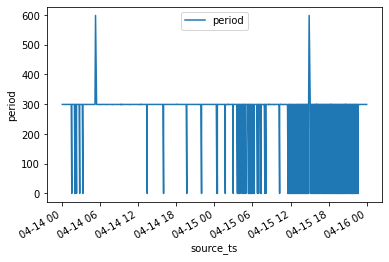

In [0]:
plot_period_function(test_signal_subset, title="")

Found 185 peaks
Found 142 peaks
Found 142 peaks
Found 2 peaks

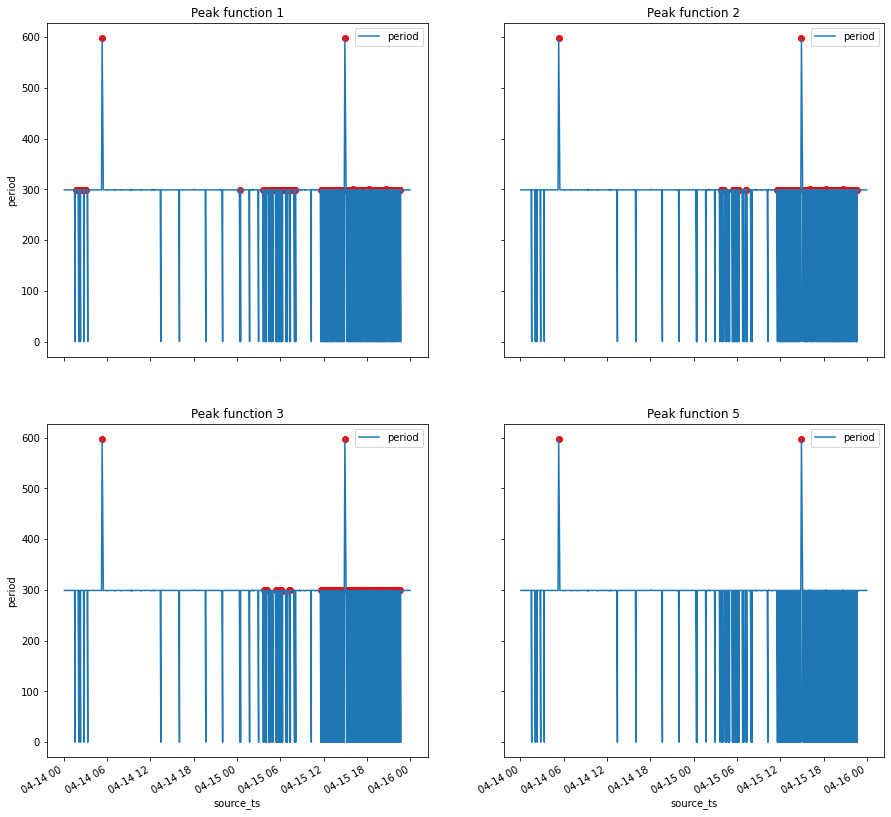

In [0]:
h = 0.1
compare_peak_functions_algo_1(test_signal_subset)

Found 2 peaks
 source_ts next period
69 2019-04-14 05:18:09 2019-04-14 05:28:07 598.0
587 2019-04-15 14:56:10 2019-04-15 15:06:08 598.0

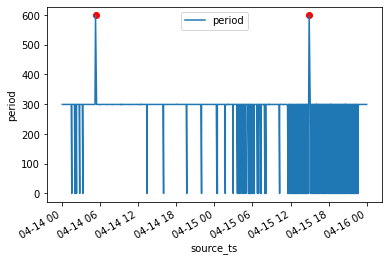

In [0]:
peaks = peak_detection_algo_1(test_signal_subset, peak_function_5)
print(str(peaks))
plot_peak_detection(test_signal_subset, peaks)

Found 11 peaks
 source_ts next period
63 2019-04-14 05:18:09 2019-04-14 05:28:07 598.0
111 2019-04-14 09:22:16 2019-04-14 09:27:16 300.0
148 2019-04-14 12:26:37 2019-04-14 12:31:37 300.0
216 2019-04-14 18:05:29 2019-04-14 18:10:29 300.0
313 2019-04-15 02:08:51 2019-04-15 02:13:51 300.0
391 2019-04-15 08:37:30 2019-04-15 08:42:30 300.0
412 2019-04-15 10:22:07 2019-04-15 10:27:07 300.0
467 2019-04-15 14:56:10 2019-04-15 15:06:08 598.0
480 2019-04-15 16:05:56 2019-04-15 16:10:56 300.0
507 2019-04-15 18:20:30 2019-04-15 18:25:30 300.0
535 2019-04-15 20:40:03 2019-04-15 20:45:03 300.0

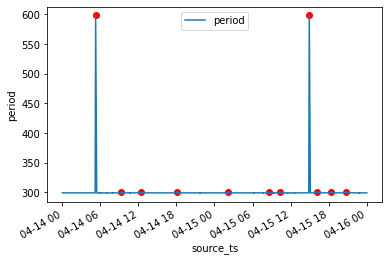

In [0]:
test_signal_no_dup = remove_duplicate_timestamps(test_signal_subset)
peaks = peak_detection_algo_2(test_signal_no_dup)
print(str(peaks))

Found 11 peaks
Out[81]:

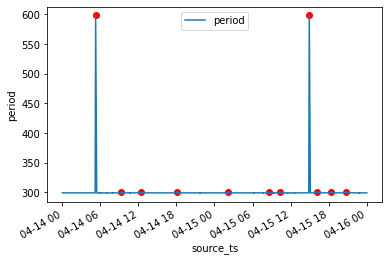

,source_ts,next,period
63,2019-04-14 05:18:09,2019-04-14 05:28:07,598.0
111,2019-04-14 09:22:16,2019-04-14 09:27:16,300.0
148,2019-04-14 12:26:37,2019-04-14 12:31:37,300.0
216,2019-04-14 18:05:29,2019-04-14 18:10:29,300.0
313,2019-04-15 02:08:51,2019-04-15 02:13:51,300.0
391,2019-04-15 08:37:30,2019-04-15 08:42:30,300.0
412,2019-04-15 10:22:07,2019-04-15 10:27:07,300.0
467,2019-04-15 14:56:10,2019-04-15 15:06:08,598.0
480,2019-04-15 16:05:56,2019-04-15 16:10:56,300.0
507,2019-04-15 18:20:30,2019-04-15 18:25:30,300.0


In [0]:
peak_detection_algo_3(test_signal_no_dup)

Found 2 peaks
 source_ts next period
63 2019-04-14 05:18:09 2019-04-14 05:28:07 598.0
467 2019-04-15 14:56:10 2019-04-15 15:06:08 598.0

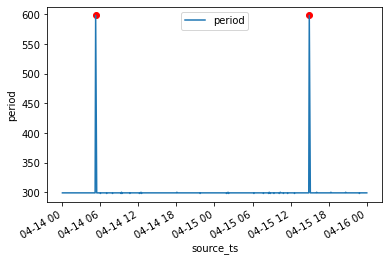

In [0]:
peaks = peak_detection_algo_1(test_signal_no_dup, peak_function_5)
print(str(peaks))
plot_peak_detection(test_signal_no_dup, peaks)

Column-wise sums: [24 26 25 26 25 26 24 24 24 24 25 24 24 22 22 24 23 23 21 22 21 24 24 23
 17 14 14 12 15 16 16 14 11 15 14 15 14 14 15 13 14 14 14 14 13 13 10 13
 12 13 13 11 11 10 11 12 12 12 12 10 8 10 9 9 8 8 9 9 8 8 8 8
 7 7 8 8 8 7 8 7 8 8 8 8 8 8 7 7 7 7 7 7 6 6 7 7
 6 6 5 7 7 7 6 7 7 6 5 7 7 7 7 7 6 6 7 7 7 7 7 6
 4 5 4 4 4 4 3 3 1 1 1 1 0 0 0 0 0 0 0]
Scale with most local maxima: 1
Out[63]:

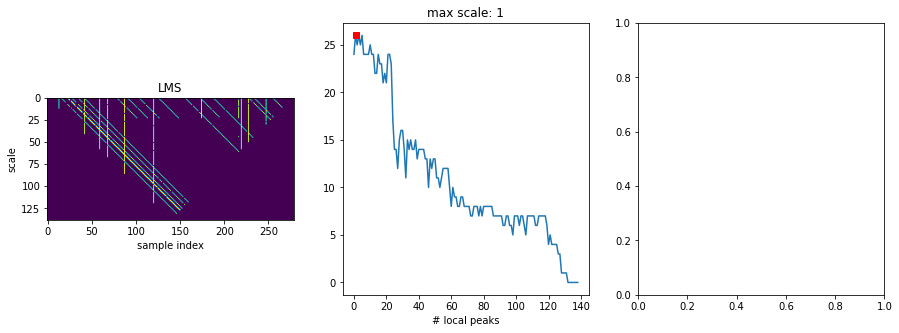

Text(0.5, 0, '# local peaks')

In [0]:
x = signal_subset.period
pks, LMS, G, l = multiscale_peak_detection(x, debug=True)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax = ax0
ax.imshow(LMS)
ax.set_title('LMS')
ax.set_xlabel('sample index')
ax.set_ylabel('scale')
ax = ax1
ax.plot(G)
ax.plot([l], G[l], 'rs')
ax.set_title('max scale: {}'.format(l))
ax.set_xlabel('scale')
ax.set_xlabel('# local peaks')